# Summary of fragmentomics features in FinaleTools
This figure presents a precise summary of all of the fragmentomics features that can be calculated using the FinaleTools package and command line program.

### Features to Represent
- Fragment Coverage
- Fragment Lengths
- Window Protection Score (WPS)
- DNA evaluation of fragments for early interception (DELFI)
- End motifs
- Motif Diversity Score (MDS)

In [20]:
# imports
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import scipy.stats as stats
import gzip
from statsmodels.regression.linear_model import OLS

In [2]:
# Window Protection Score
ft_wps = []
with open("../data/BH01.chr12_asat.LWPS.raw.bedGraph", 'r') as ft_wps_file:
    for line in ft_wps_file:
        contents = line.split()
        ft_wps.append((contents[0], int(contents[1]), int(contents[2]), float(contents[3])))

shendure_wps = []
with gzip.open('../data/shendure.BH01.chr12.asat.wps.wig.gz', 'rt') as shendure_file:
    lines = shendure_file.readlines()
    header = lines[0].split()
    chrom = header[1].split('=')[1][3:]
    start = int(header[2].split('=')[1])
    step = int(header[3].split('=')[1])
    pos = start
    for line in lines[1:]:
        score = float(line)
        shendure_wps.append((chrom, pos, pos+1, score))
        pos += 1
ft_wps = np.array(ft_wps, dtype=[('chrom', '<U16'), ('start', '<i8'), ('stop', '<i8'), ('score', '<f8')])
shendure_wps = np.array(shendure_wps, dtype=[('chrom', '<U16'), ('start', '<i8'), ('stop', '<i8'), ('score', '<f8')])
ft_wps, shendure_wps

(array([('12', 34442000, 34442001, -24.), ('12', 34442001, 34442002, -24.),
        ('12', 34442002, 34442003, -26.), ...,
        ('12', 34446997, 34446998, -23.), ('12', 34446998, 34446999, -24.),
        ('12', 34446999, 34447000, -24.)],
       dtype=[('chrom', '<U16'), ('start', '<i8'), ('stop', '<i8'), ('score', '<f8')]),
 array([('12', 34442000, 34442001, -52.), ('12', 34442001, 34442002, -49.),
        ('12', 34442002, 34442003, -51.), ...,
        ('12', 34446998, 34446999, -62.), ('12', 34446999, 34447000, -64.),
        ('12', 34447000, 34447001, -61.)],
       dtype=[('chrom', '<U16'), ('start', '<i8'), ('stop', '<i8'), ('score', '<f8')]))

In [3]:
# Get stats
pearson, _ = stats.pearsonr(ft_wps['score'], shendure_wps['score'][:-1])
spearman, _ = stats.spearmanr(ft_wps['score'], shendure_wps['score'][:-1])

pearson, spearman

(0.9348921380863161, 0.9362639734208263)

In [29]:
# Regression line
ols = OLS(shendure_wps['score'][:-1], ft_wps['score'])
model = ols.fit()
regression = model.predict(ft_wps['score'])
r2 = model.rsquared_adj
r2

0.9732501042161789

Text(-15, -80, "$R^2=0.9733$\nPearson's $\\rho = 0.9349$\nSpearman's $r = 0.9363$\n")

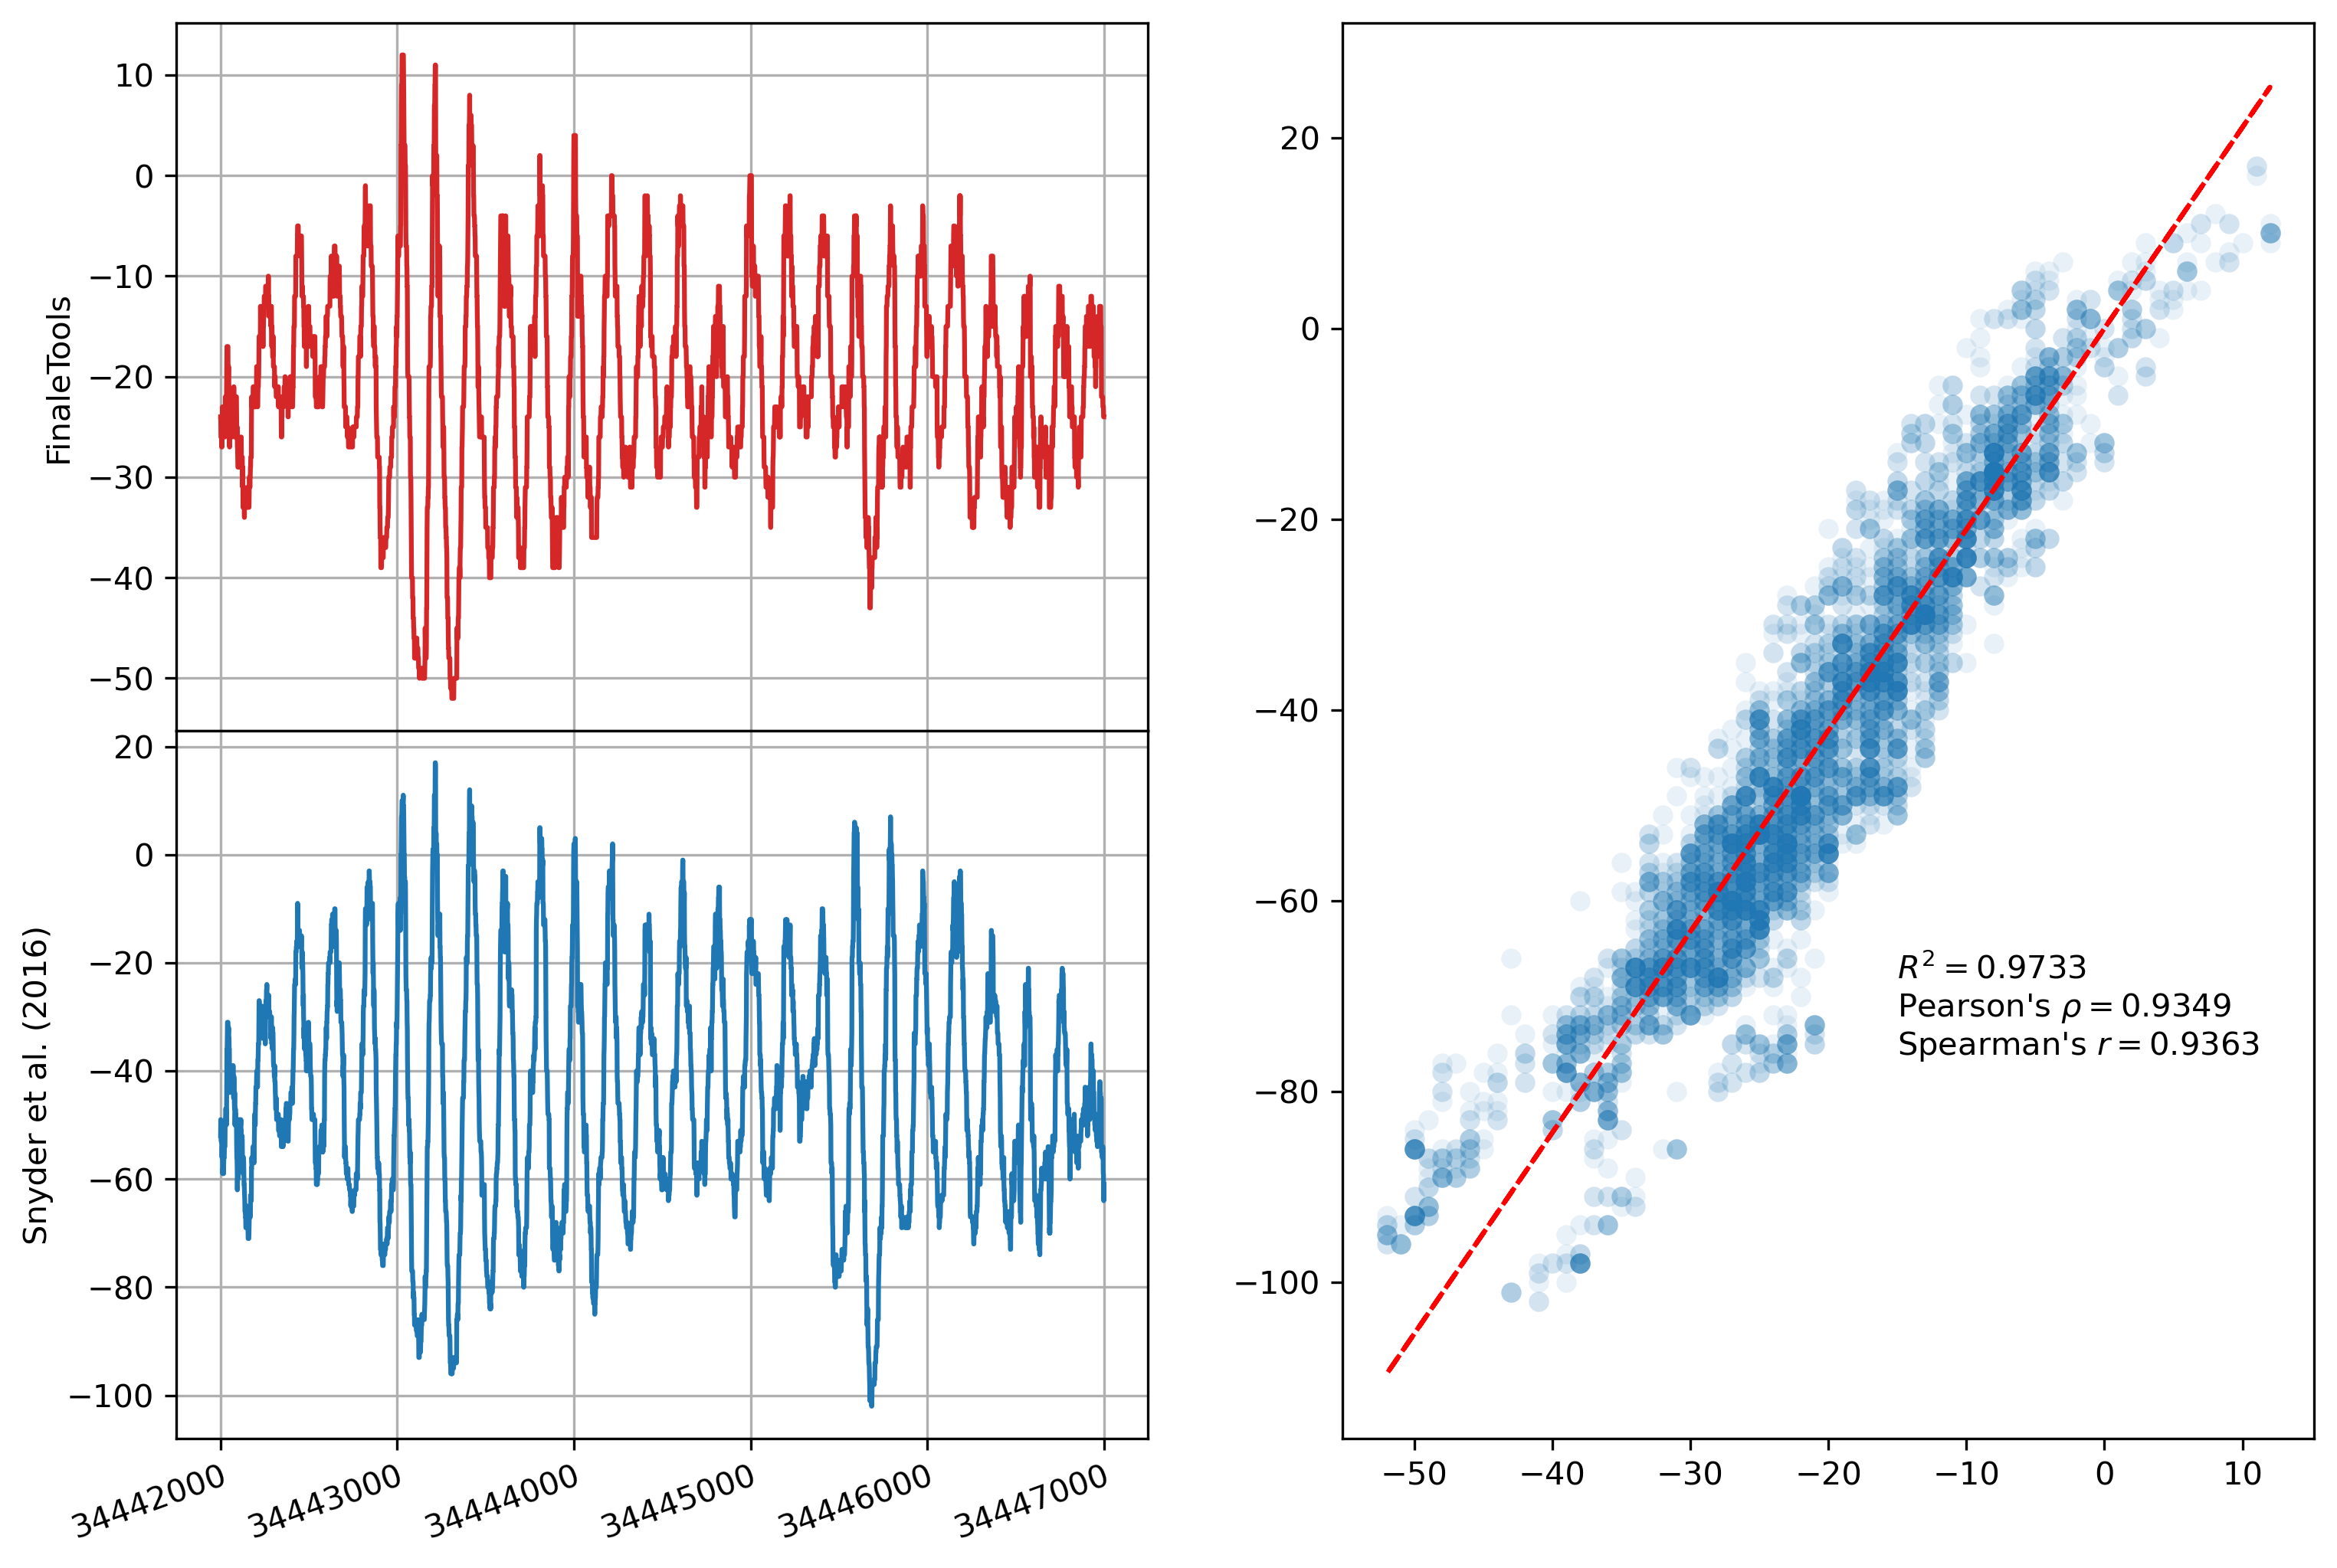

In [36]:
# plotting comparison
fig, axes = plt.subplots(2, 2, sharex=True)
fig.set_dpi(300)
fig.set_size_inches(12, 6)
axes[0, 0].plot(ft_wps['start'], ft_wps['score'], 'C3', label="FinaleTools")
axes[0, 0].set_ylabel('FinaleTools')
axes[1, 0].plot(shendure_wps['start'], shendure_wps['score'], 'C0', label="Snyder et al. (2016)")
axes[1, 0].set_ylabel('Snyder et al. (2016)')

plt.setp(axes[1, 0].get_xticklabels(), rotation=20, ha="right",
         rotation_mode="anchor")
x_formatter = mpl.ticker.ScalarFormatter(useOffset=False, useMathText=False)
x_formatter.set_scientific(False)

fig.subplots_adjust(hspace=0)

axes[1, 0].xaxis.set_major_formatter(x_formatter)
axes[0, 0].grid()
axes[1, 0].grid()

gs = axes[0, 1].get_gridspec()
for ax in axes[:, 1]:
    ax.remove()

scatter_ax = fig.add_subplot(gs[:, 1])
scatter_ax.scatter(ft_wps['score'], shendure_wps['score'][:-1], s=40, alpha=0.1, linewidths=0)
scatter_ax.plot(ft_wps['score'], regression, 'r--')
stats_string = f"""$R^2={r2:.4f}$
Pearson's $\\rho = {pearson:.4f}$
Spearman's $r = {spearman:.4f}$
"""
scatter_ax.text(-15, -80, stats_string)
